## Unconditional density estmation
An example of unconditional density estimation, using the "two moons" distribution.

### Imports

In [1]:
import jax.numpy as jnp
from jax import random
import optax
from jaxflows.bijections.coupling import CouplingStack
from jaxflows.bijections.rational_quadratic_spline import RationalQuadraticSpline
from jaxflows.flow import Flow
from jaxflows.train_utils import train_flow
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing


### Generate data

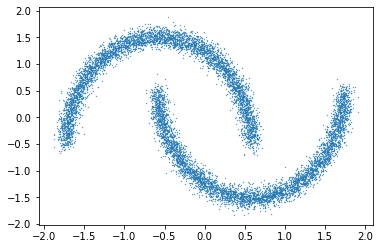

In [2]:
n_samples = 10000
n_bins = 100

scaler = preprocessing.StandardScaler()
x, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
x = scaler.fit_transform(x)
x = jnp.array(x)
plt.scatter(x[:, 0], x[:, 1], s=0.1)

### Train and plot samples

In [3]:
# %%time
key = random.PRNGKey(1)
bijection = CouplingStack(
    key=key,
    bijection=RationalQuadraticSpline(K=8, B=4),
    D=2,
    num_layers=5)

flow = Flow(bijection, target_dim = x.shape[1])
key, subkey = random.split(key)
flow, losses = train_flow(flow, key, x)


 98%|█████████▊| 49/50 [01:19<00:01,  1.62s/it, train=1.19, val=1.17]

Max patience reached.


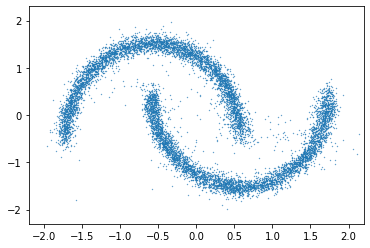

In [6]:
key, subkey = random.split(key)
x_samples = flow.sample(key, 10000)
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=0.1)
plt.xlim(-2.2, 2.2)
plt.ylim(-2.3, 2.3)
plt.show()

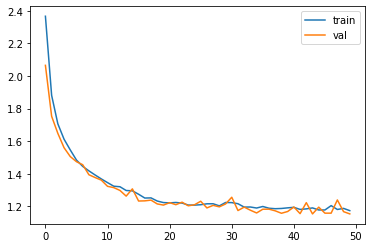

In [5]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend()